<a href="https://colab.research.google.com/github/Disha1203/Privacy-preserving-FL/blob/main/iid_data_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y ray flwr
!pip install -U "ray==2.31.0" "flwr[simulation]==1.12.0" imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.6/478.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully u

In [1]:
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import flwr as fl
from flwr.common import parameters_to_ndarrays

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Directories
# -------------------------
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)

# -------------------------
# Device
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -------------------------
# FL Hyperparameters
# -------------------------
NUM_CLIENTS = 4
NUM_ROUNDS = 3
EPOCHS_PER_CLIENT = 3
BATCH_SIZE = 32
LR = 0.001

Device: cpu


In [3]:
# -------------------------
# Load Dataset
# -------------------------
combined = pd.read_csv('/content/Dataset.csv')

# Split train/test based on Patient_ID length
df_train = combined[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)].copy()
df_test = combined[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)].copy()

# Drop rows with NaN target
df_train.dropna(subset=['SepsisLabel'], inplace=True)
df_test.dropna(subset=['SepsisLabel'], inplace=True)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
# -------------------------
# Undersampling Majority Class
# -------------------------
minority_class = df_train[df_train['SepsisLabel'] == 1]
majority_class = df_train[df_train['SepsisLabel'] == 0]

# Keep 2x minority samples from majority class
majority_class_subset = majority_class.sample(n= 3 * len(minority_class), random_state=SEED)

# Combine undersampled majority + minority
df_train_balanced = pd.concat([majority_class_subset, minority_class])

# Shuffle
df_train_balanced = df_train_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)



In [14]:
# -------------------------
# Features and Labels
# -------------------------
X_train = df_train_balanced.drop(columns=['SepsisLabel', 'Patient_ID'])
y_train = df_train_balanced['SepsisLabel'].values.astype(int)  # Convert to int

X_test = df_test.drop(columns=['SepsisLabel', 'Patient_ID'])
y_test = df_test['SepsisLabel'].values.astype(int)  # Convert to int

# -------------------------
# Impute Missing Values
# -------------------------
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# -------------------------
# Standardize
# -------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------------
# Convert to PyTorch Datasets
# -------------------------
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

print("Balanced train class counts:", np.bincount(y_train))
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Balanced train class counts: [56004 18668]
Shape of X_train: (74672, 42)
Shape of X_test: (349653, 42)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
# -------------------------
# Split Train Dataset Among Clients
# -------------------------
client_size = len(train_dataset) // NUM_CLIENTS
lengths = [client_size] * (NUM_CLIENTS - 1)
lengths.append(len(train_dataset) - sum(lengths))

client_datasets = random_split(train_dataset, lengths)
client_loaders = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of clients: {NUM_CLIENTS}")
print(f"Samples per client: {[len(ds) for ds in client_datasets]}")

Number of clients: 4
Samples per client: [18668, 18668, 18668, 18668]


In [16]:
# -------------------------
# Model
# -------------------------
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 2

class SepsisNet(nn.Module):
    def __init__(self, num_features=NUM_FEATURES, num_classes=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

In [17]:
# -------------------------
# Focal Loss
# -------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.95, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


In [18]:
# -------------------------
# Dump outputs for attack evaluation (optional)
# -------------------------
def dump_outputs(model, loader, path_prefix):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            outputs = model(xb)
            probs = F.softmax(outputs, dim=1).cpu().numpy()[:, 1]
            all_probs.append(probs)
            all_labels.append(yb.numpy())
    if all_probs:
        probs = np.concatenate(all_probs)
        labels = np.concatenate(all_labels)
    else:
        probs = np.zeros((0,))
        labels = np.zeros((0,), dtype=int)
    np.savez_compressed(f"{path_prefix}.npz", probs=probs, labels=labels)
    return f"{path_prefix}.npz"

In [19]:
# -------------------------
# Federated Client
# -------------------------
class SepsisClient(fl.client.NumPyClient):
    def __init__(self, model, trainloader, testloader, cid):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.cid = cid

    def get_parameters(self, config):
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters):
        state_dict = dict(zip(self.model.state_dict().keys(),
                              [torch.tensor(p) for p in parameters]))
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(DEVICE)
        self.model.train()
        opt = torch.optim.Adam(self.model.parameters(), lr=LR)
        crit = FocalLoss(alpha=0.75, gamma=2)
        for _ in range(EPOCHS_PER_CLIENT):
            for x, y in self.trainloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                opt.zero_grad()
                loss = crit(self.model(x), y)
                loss.backward()
                opt.step()
        round_no = config.get("round", 0)
        dump_outputs(self.model, self.trainloader,
                     f"logs/client_{self.cid}_train_outputs_round{round_no}")
        dump_outputs(self.model, self.testloader,
                     f"logs/client_{self.cid}_test_outputs_round{round_no}")
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(DEVICE).eval()
        crit = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in self.testloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = self.model(x)
                total_loss += crit(out, y).item()
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = correct / total
        return total_loss / len(self.testloader), total, {"accuracy": acc}

# -------------------------
# Logging Strategy
# -------------------------
class LoggingFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated = super().aggregate_fit(rnd, results, failures)
        if aggregated is None:
            return None
        parameters, num_examples = aggregated
        try:
            ndarrays = parameters_to_ndarrays(parameters)
            model = SepsisNet()
            keys = list(model.state_dict().keys())
            state_dict = {k: torch.tensor(p) for k, p in zip(keys, ndarrays)}
            save_path = os.path.join(LOG_DIR, f"global_model_round{rnd}.pth")
            torch.save(state_dict, save_path)
            print(f"Saved global model state for round {rnd} -> {save_path}")
        except Exception as e:
            print("Warning: could not save global model state:", e)
        return aggregated

In [20]:
# -------------------------
# Client function
# -------------------------
def client_fn(cid: str):
    model = SepsisNet()
    cid_int = int(cid)
    return SepsisClient(model, client_loaders[cid_int], test_loader, cid)

# -------------------------
# Start FL Simulation
# -------------------------
strategy = LoggingFedAvg()
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)


INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-10-18 09:46:25,559	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7836337767.0, 'object_store_memory': 3918168883.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEn

Saved global model state for round 1 -> logs/global_model_round1.pth


(ClientAppActor pid=12269) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=12269) 
(ClientAppActor pid=12269)             This is a deprecated feature. It will be removed
(ClientAppActor pid=12269)             entirely in future versions of Flower.
(ClientAppActor pid=12269)         
(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=12270) 
(ClientAppActor pid=12270)         
(ClientAppActor pid=12270) 
(ClientAppActor pid=12270)         
(ClientAppActor pid=12270) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context

Saved global model state for round 2 -> logs/global_model_round2.pth


(ClientAppActor pid=12269) 
(ClientAppActor pid=12269)         
(ClientAppActor pid=12269) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=12269)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=12269)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=12270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned

Saved global model state for round 3 -> logs/global_model_round3.pth


(ClientAppActor pid=12269) 
(ClientAppActor pid=12269)         
(ClientAppActor pid=12269) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=12269)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=12269)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=12270) 
(ClientAppActor pid=12270)         
(ClientAppActor pid=12269) 
(ClientAppActor pid=12269)         
(ClientApp

History (loss, distributed):
	round 1: 0.5045960028915356
	round 2: 0.48232619177338365
	round 3: 0.47877506444959744

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Evaluation loss on test set: 0.47877506444959744
Evaluation accuracy on test set: 0.9309715632355506
Classification Report:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

           0       0.98      0.94      0.96    342236
           1       0.11      0.33      0.17      7417

    accuracy                           0.93    349653
   macro avg       0.55      0.64      0.57    349653
weighted avg       0.97      0.93      0.95    349653

AUC: 0.7572


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


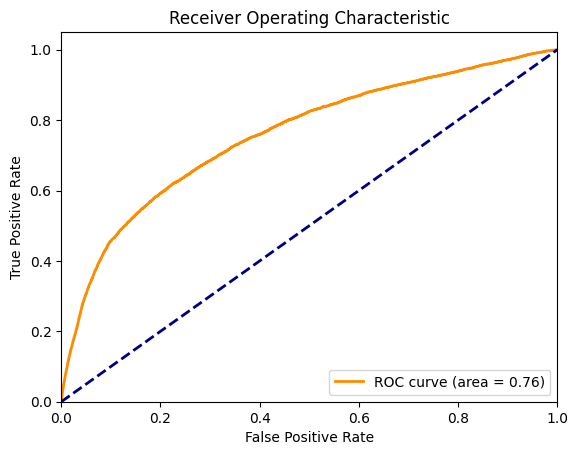

In [21]:
# -------------------------
# Load and Evaluate Final Global Model
# -------------------------
final_model_path = os.path.join(LOG_DIR, f"global_model_round{NUM_ROUNDS}.pth")
final_model_state_dict = torch.load(final_model_path)

final_global_model = SepsisNet()
final_global_model.load_state_dict(final_model_state_dict)

dummy_client = SepsisClient(final_global_model, client_loaders[0], test_loader, cid="dummy")
loss, num_examples, metrics = dummy_client.evaluate(dummy_client.get_parameters({}), {})
print(f"Evaluation loss on test set: {loss}")
print(f"Evaluation accuracy on test set: {metrics['accuracy']}")

# -------------------------
# Classification Report and ROC
# -------------------------
final_global_model.to(DEVICE).eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        outputs = final_global_model(X_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

print("Classification Report:")
print(classification_report(all_labels, all_preds))

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()